In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
import torchvision.transforms.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as tx
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class GE_Thyroid_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        image_type = self.df["image_type"][idx]

        if image_type == "train":
            from_folder = "../ge_data/train"
        else:
            from_folder = "../ge_data/test"

        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        contour_image = self.get_contour_from_mask_tensor(mask_tensor)
        return image_tensor, mask_tensor, contour_image, mask_name, image_type
    def get_contour_from_mask_tensor(self, mask_tensor):
        """
        Extract contours from a transformed segmentation mask tensor.
        Args:
            mask_tensor (torch.Tensor): Shape (1, H, W) or (H, W)
        Returns:
            contours: List of contour points
            contour_image: Image with contours drawn (for visualization)
        """
        # Remove channel if exists and convert to NumPy
        if mask_tensor.dim() == 3:
            mask_np = mask_tensor.squeeze().cpu().numpy()
        else:
            mask_np = mask_tensor.cpu().numpy()
    
        # Binarize and convert to uint8
        mask_bin = (mask_np > 0.5).astype(np.uint8) * 255
    
        # OpenCV expects a CV_8UC1 image
        contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        # Optional: visualize the contour
        contour_image = np.zeros_like(mask_bin)
        cv2.drawContours(contour_image, contours, -1, 255, thickness=3)
        contour_image = contour_image.astype(np.float32) / 255.0
        
        contour_image = torch.tensor(contour_image)
        contour_image = torch.unsqueeze(contour_image, 0)
    
        return contour_image

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
image_size = 128
batch_size = 1
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor

test_dataset = GE_Thyroid_Dataset("../ge_data/all_data.csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

image, mask, contour, mask_name, image_type = next(iter(test_dataloader))

In [5]:
print("std : ", torch.std(image))
print("unique : ", torch.unique(mask))

std :  tensor(1.)
unique :  tensor([0., 1.])


In [7]:
# for i in range(20):
#     print(mask_name[i])
#     print(image_type[i])
#     plt.subplot(1,3,1)
#     plt.imshow(image[i][0])
#     plt.subplot(1,3,2)
#     plt.imshow(contour[i][0])
#     plt.subplot(1,3,3)
#     plt.imshow(mask[i][0])
#     plt.show()
    

In [13]:
def average_mask_contour(mask_preds, contour_preds, weight_mask=0.7, threshold=0.5):
    prob_mask = torch.sigmoid(mask_preds)
    prob_contour = torch.sigmoid(contour_preds)

    combined = weight_mask * prob_mask + (1 - weight_mask) * prob_contour
    return (combined > threshold).float()  # shape: (B, 1, H, W)

In [8]:
import torch
import numpy as np
import cv2
import scipy.ndimage as ndi
def average_mask_contour_v2(mask_preds, contour_preds, weight_mask=0.7, threshold=0.5):
    """
    Combines mask and contour predictions using weighted average.
    
    Args:
        mask_preds (Tensor): raw logits of mask prediction (B, 1, H, W)
        contour_preds (Tensor): raw logits of contour prediction (B, 1, H, W)
        weight_mask (float): weight for the mask prediction
        threshold (float): binarization threshold

    Returns:
        Tensor: refined binary mask (B, 1, H, W)
    """
    prob_mask = torch.sigmoid(mask_preds)
    prob_contour = torch.sigmoid(contour_preds)

    refined_batch = []
    
    for b in range(prob_mask.shape[0]):
        mask_np = prob_mask[b, 0].detach().cpu().numpy()
        mask_np = ndi.binary_fill_holes(mask_np).astype(np.uint8)
        contour_np = prob_contour[b, 0].detach().cpu().numpy()

        contour_uint8 = (contour_np * 255).astype(np.uint8)

        # Find external contours
        contours, _ = cv2.findContours(contour_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create a clean mask by filling inside the contours
        clean_mask = np.zeros_like(contour_uint8)
        cv2.drawContours(clean_mask, contours, -1, color=255, thickness=cv2.FILLED)
        clean_mask = (clean_mask > 0).astype(np.float32)  # convert to 0.0 / 1.0

        # Weighted average
        # combined = weight_mask * mask_np + (1 - weight_mask) * clean_mask
        refined = np.logical_and(mask_np, clean_mask).astype(np.float32)
        # Binarize result
        final_mask = (refined > threshold).astype(np.float32)
        refined_batch.append(torch.from_numpy(final_mask).unsqueeze(0))  # shape: (1, H, W)

    return torch.stack(refined_batch, dim=0)  # shape: (B, 1, H, W)


In [14]:
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, contour, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        if torch.sum(mask) == 0:
            continue
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        
        IOU = IOU_score(output, mask)


        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)
    

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)

def val_post_process(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, contour, mask_name, image_type in tqdm(dataloader):
        image, mask, contour = image.to(device), mask.to(device), contour.to(device)
        if torch.sum(mask) == 0:
            continue
        outputs = model(image)

        image_pred, contour_pred = outputs[:, 0:2], outputs[:, 2:4]

        nodule_image_pred = image_pred[:, 0:1]
        nodule_contour_pred = contour_pred[:, 0:1]

        nodule_image_mask = mask
        nodule_contour_mask = contour

        refined_nodule_image_output = average_mask_contour(nodule_image_pred, nodule_contour_pred).to(device)

        # print(mask.device)
        # print(refined_nodule_image_output.device)
        loss = loss_fn(refined_nodule_image_output, mask)

        
        IOU = IOU_score(refined_nodule_image_output, mask, need_act = False)


        dice_loss = DiceLoss(need_act = False)
        DICE = 1 - dice_loss(refined_nodule_image_output, mask)
    

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)

In [10]:
inference_name = "hybrid_v3_contour_1_decoder_equal_loss"
model =  HybridSegModel(in_channels = 1, out_channels = 4, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [11]:
loss_fn = StructureLoss()
total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")

/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 677/677 [00:13<00:00, 51.19it/s]

val loss : 1.2791540305758862, val IOU : 0.5272700413629473, val DICE : 0.632054435801823


In [15]:
loss_fn = StructureLoss()
total_loss_val, total_IOU_val, total_DICE_val = val_post_process(test_dataloader, model, loss_fn, "cuda")
print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")

100%|██████████| 677/677 [00:12<00:00, 52.70it/s]

val loss : 1.388988117347616, val IOU : 0.5252003678509128, val DICE : 0.6307317684989208


In [49]:
# image, mask, seg_type, from_dataset = next(iter(test_dataloader))
model.to("cpu")
outputs = model(image)
print(outputs.shape)

torch.Size([128, 4, 128, 128])


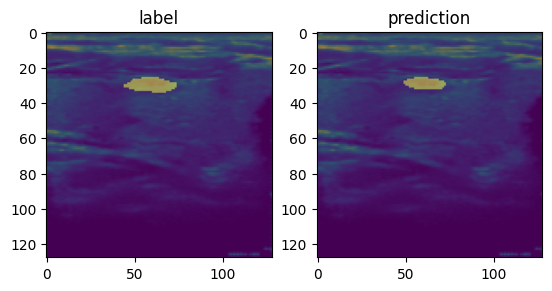

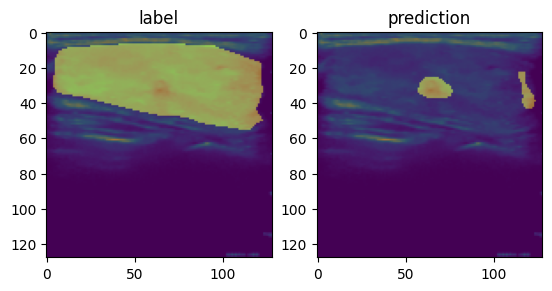

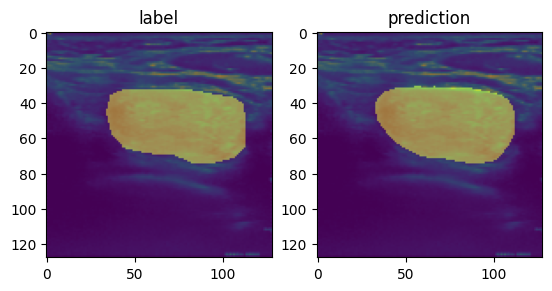

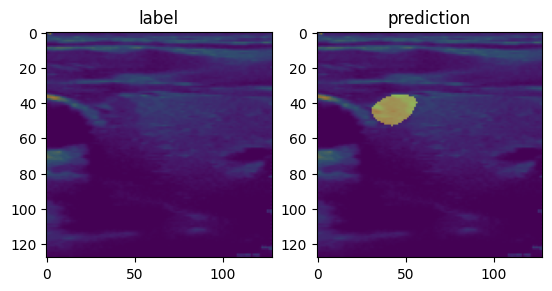

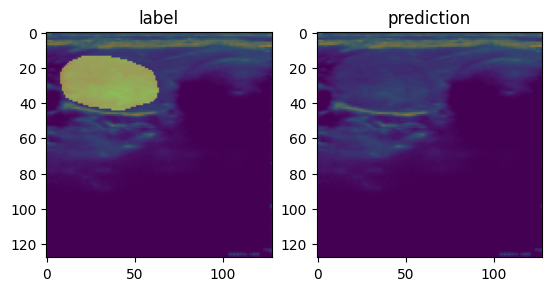

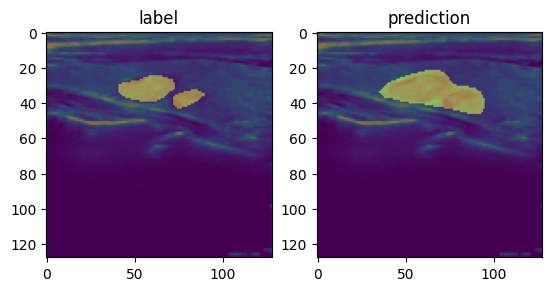

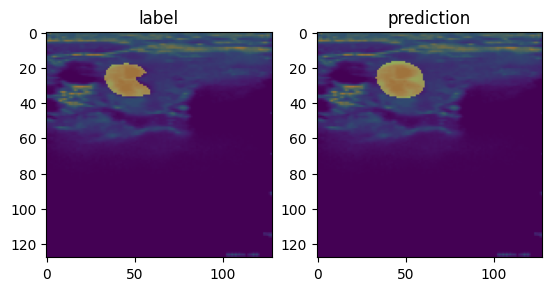

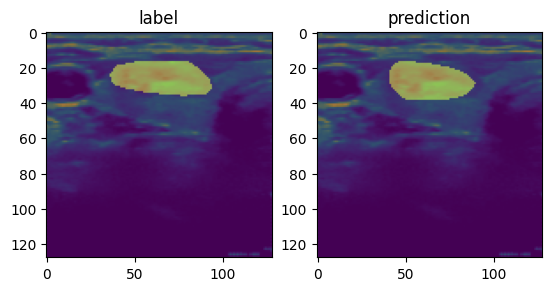

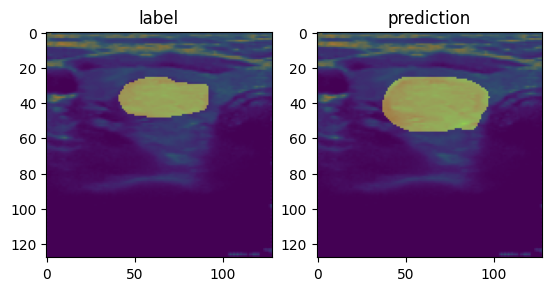

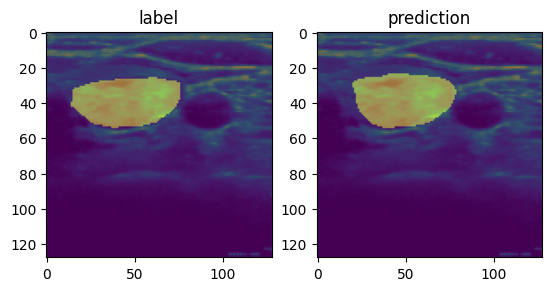

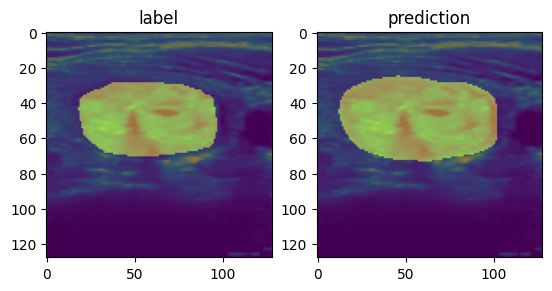

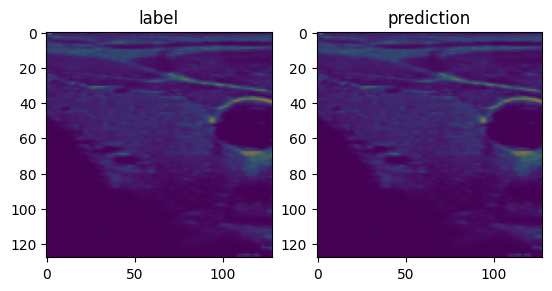

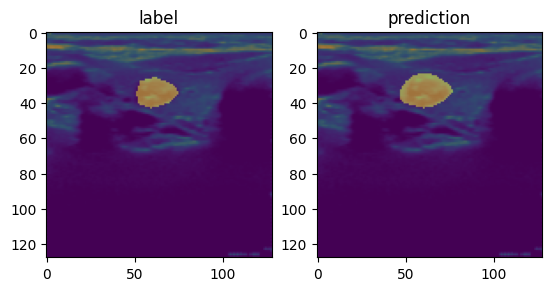

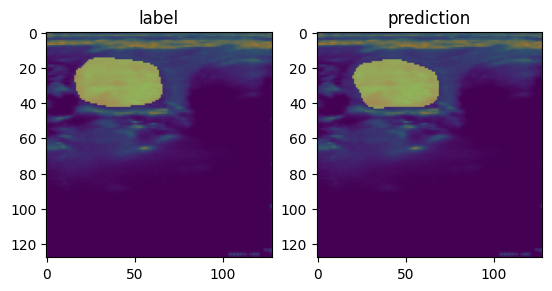

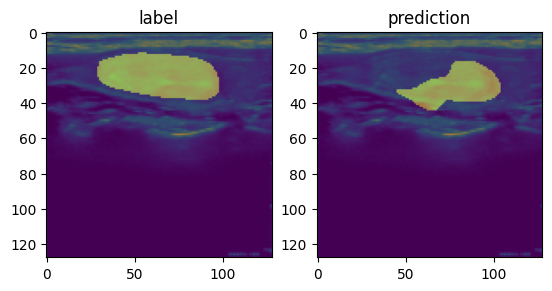

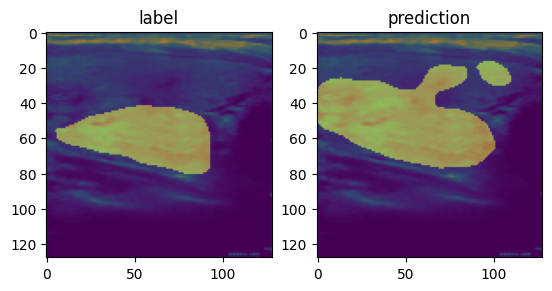

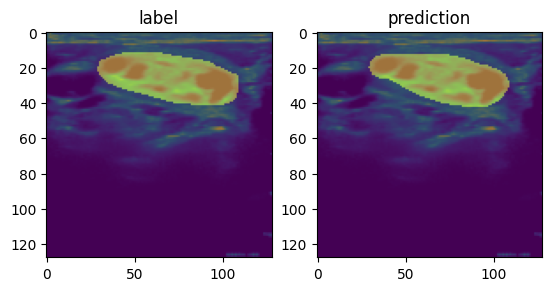

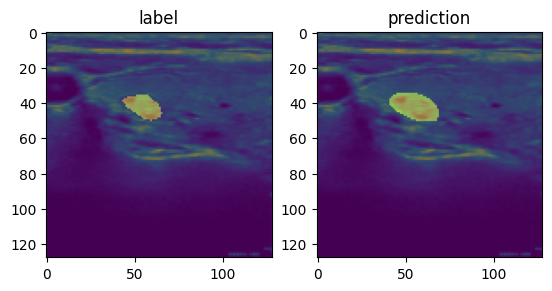

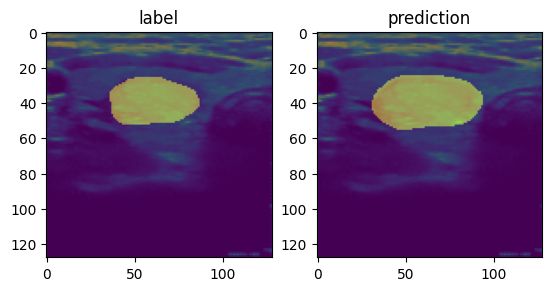

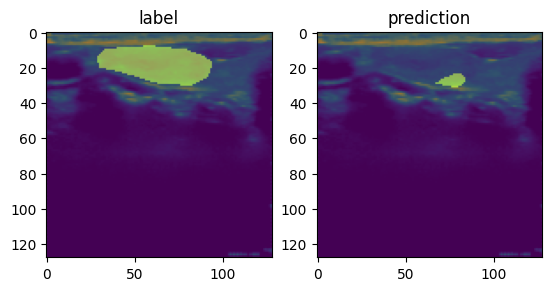

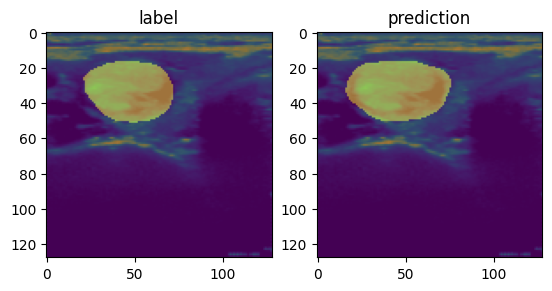

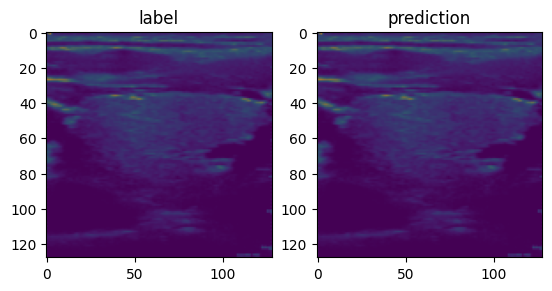

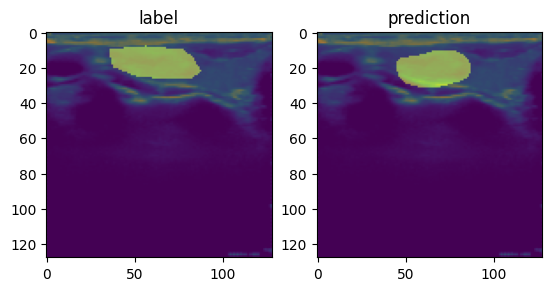

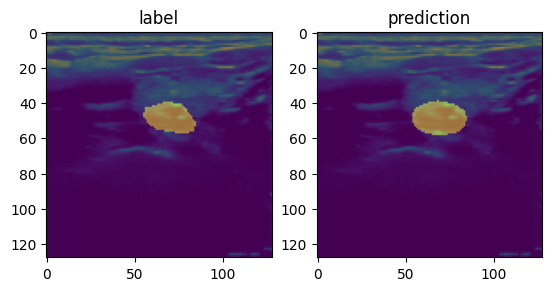

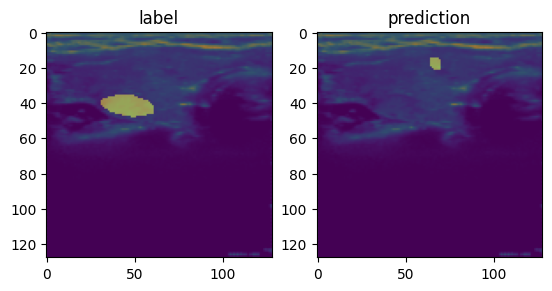

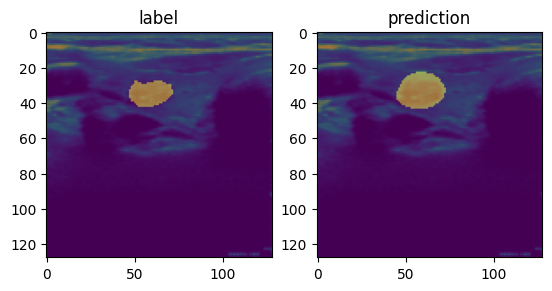

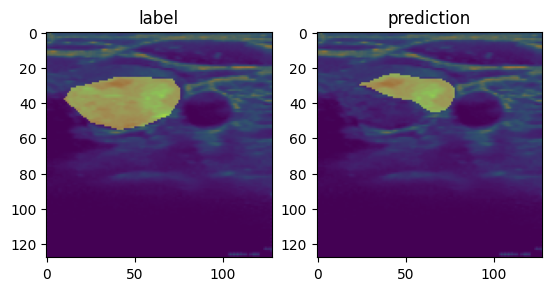

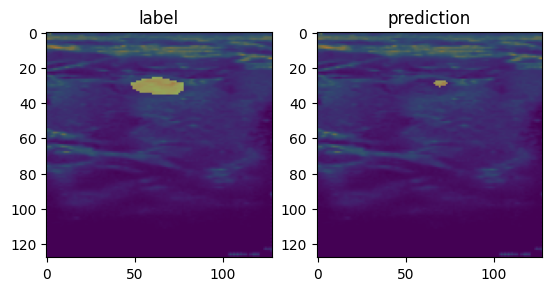

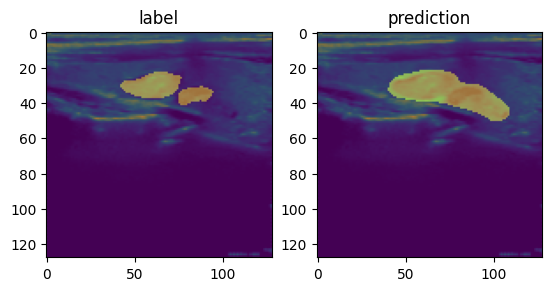

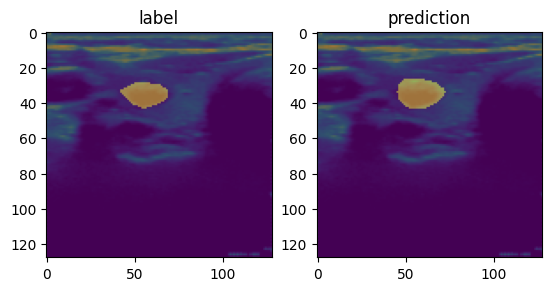

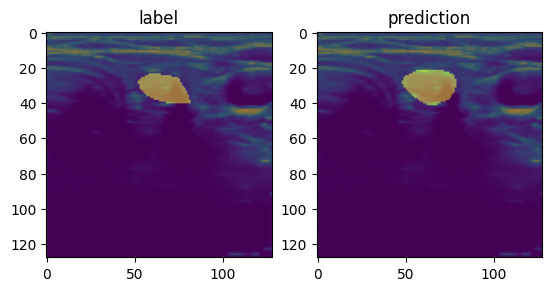

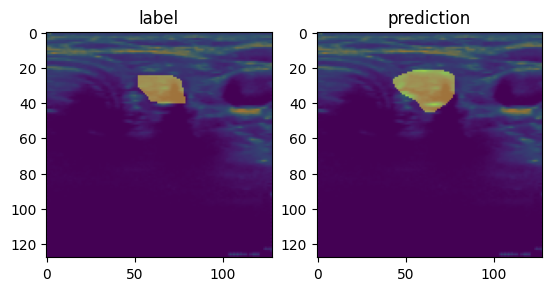

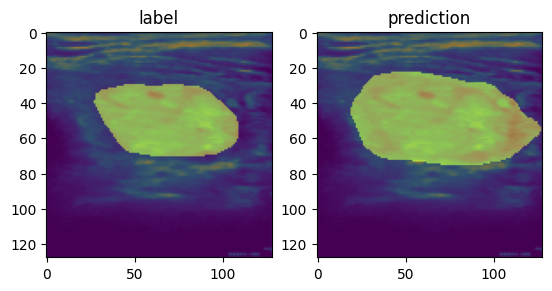

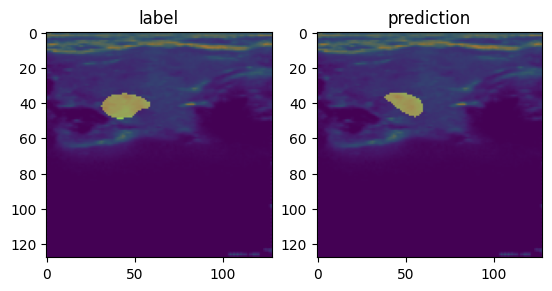

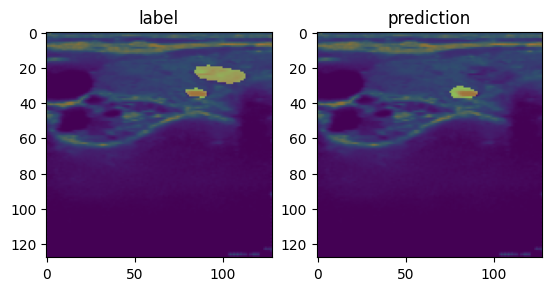

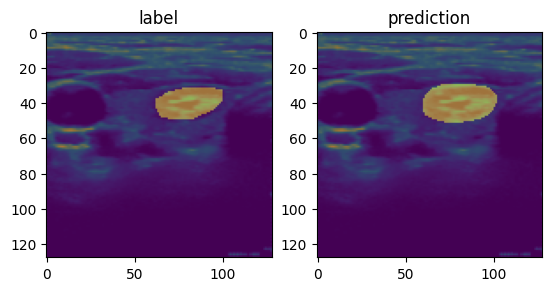

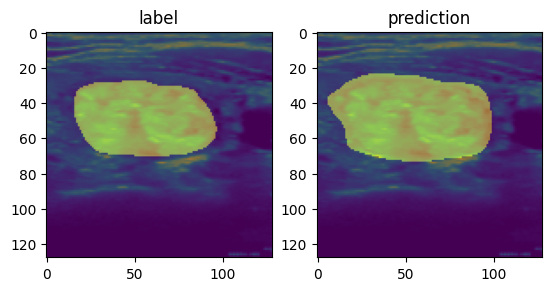

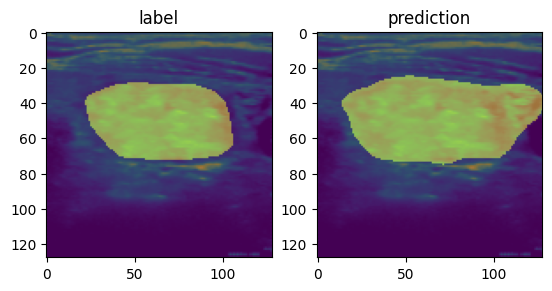

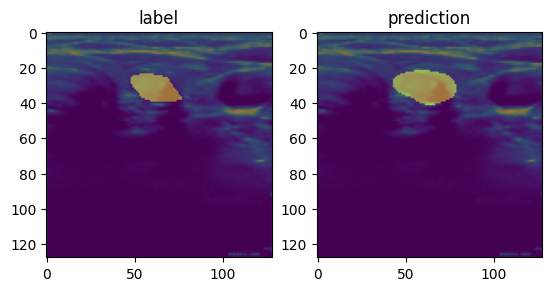

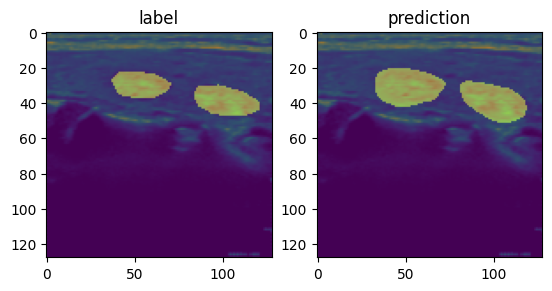

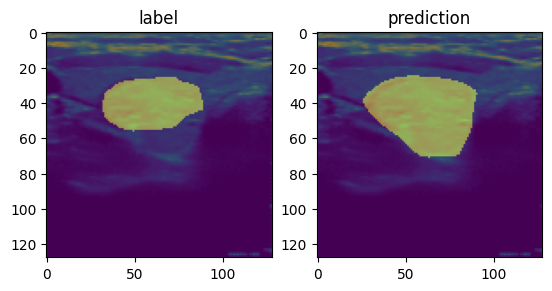

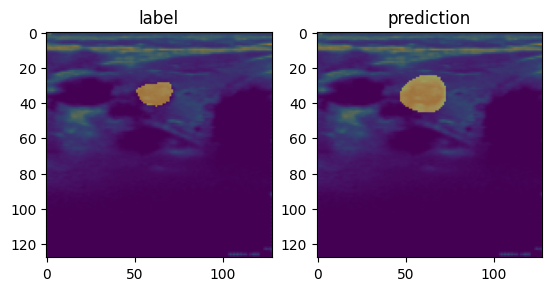

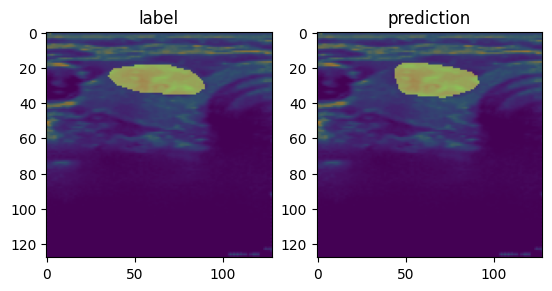

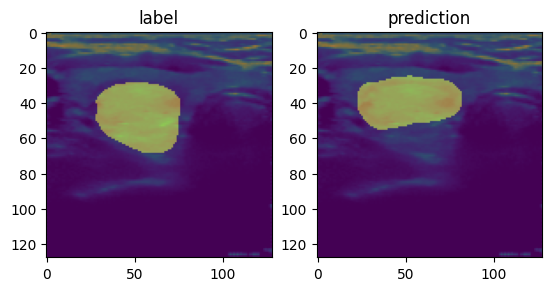

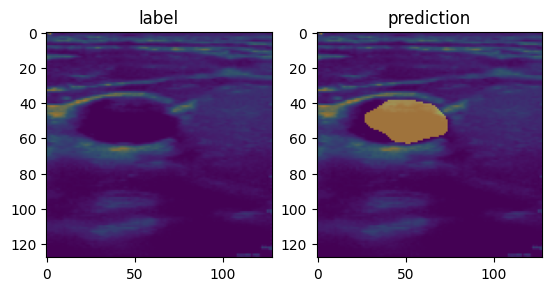

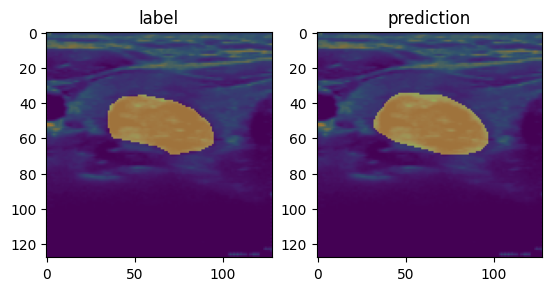

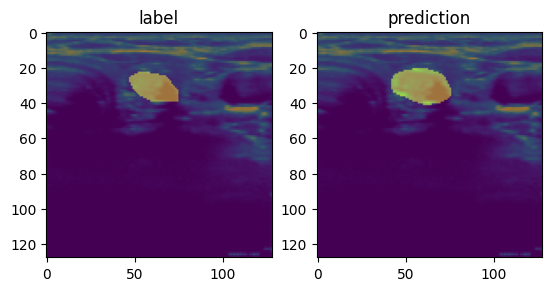

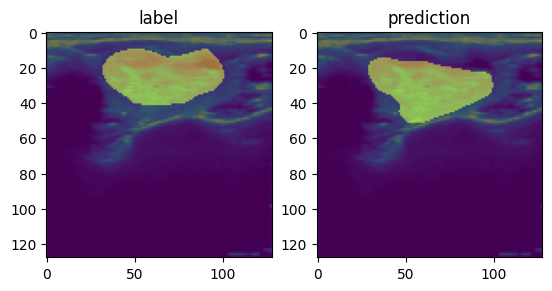

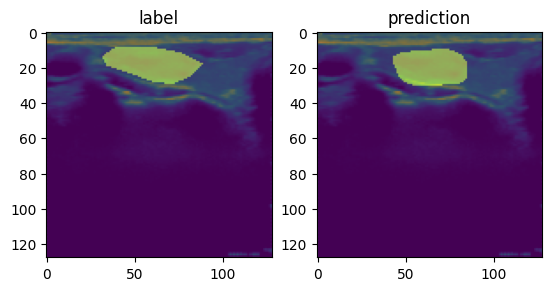

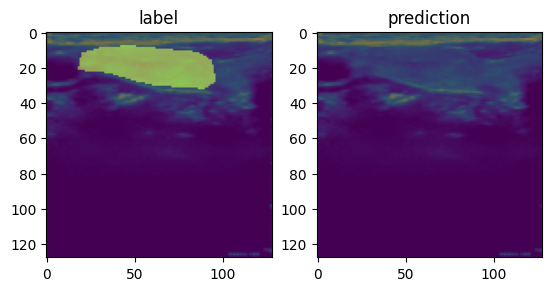

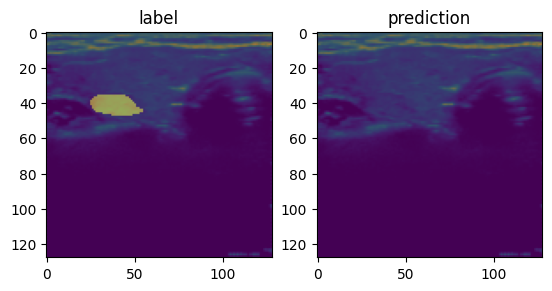

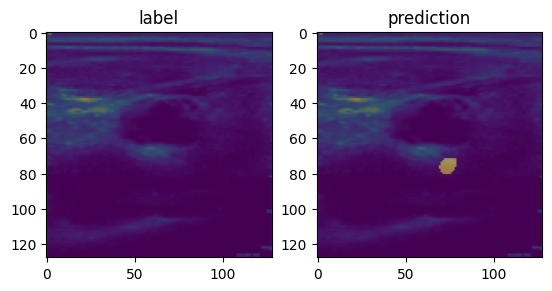

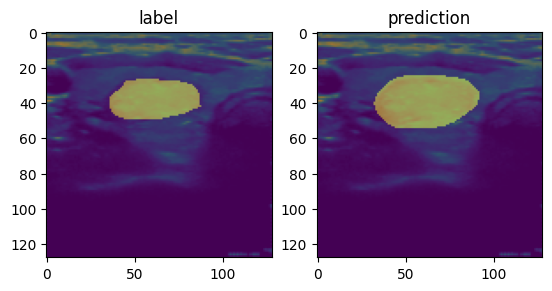

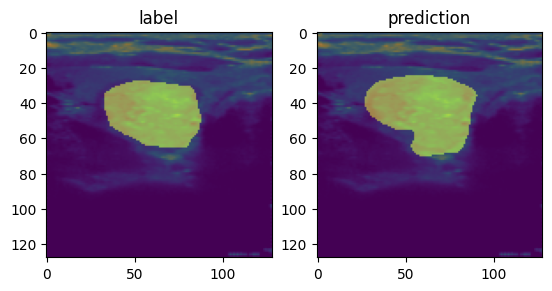

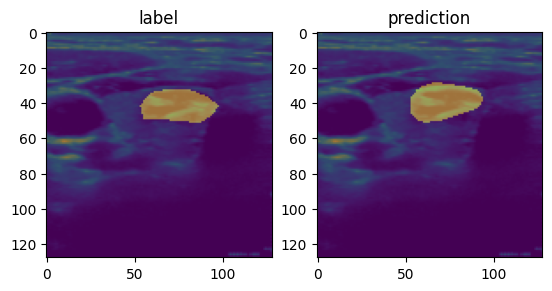

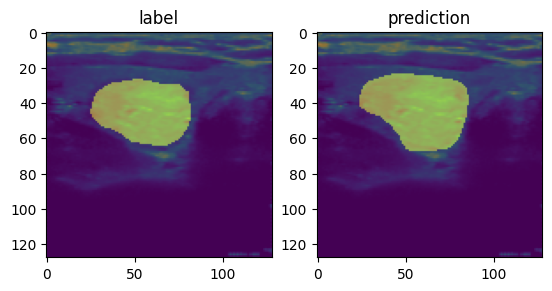

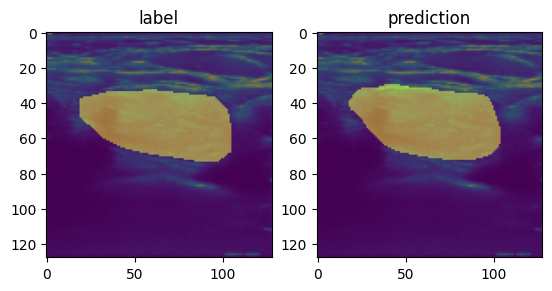

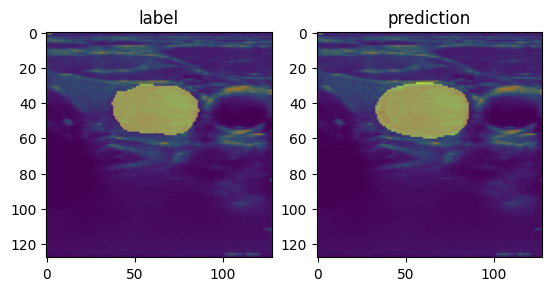

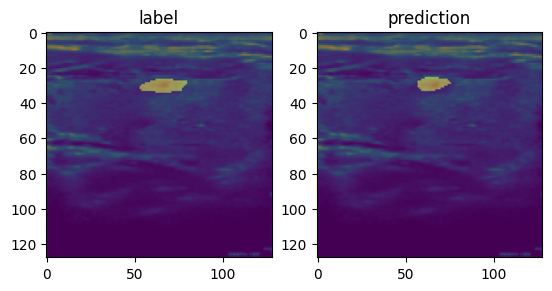

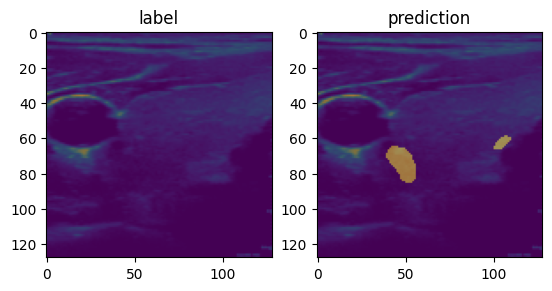

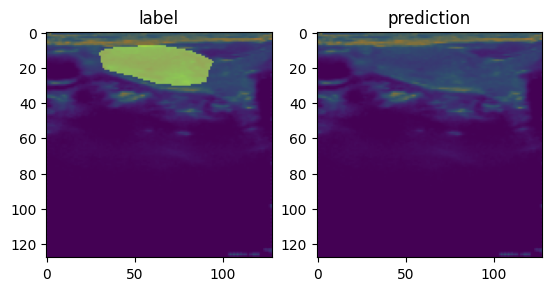

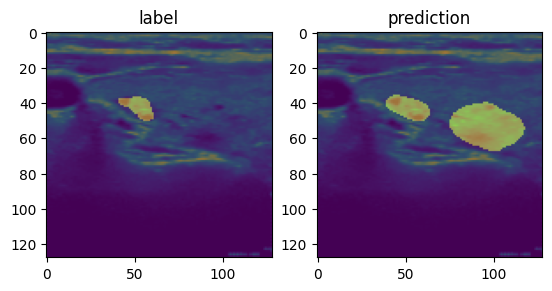

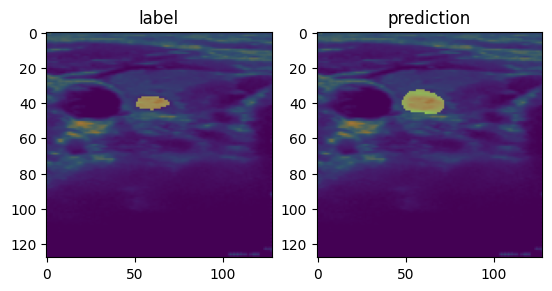

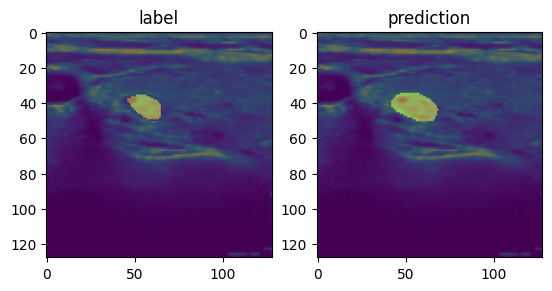

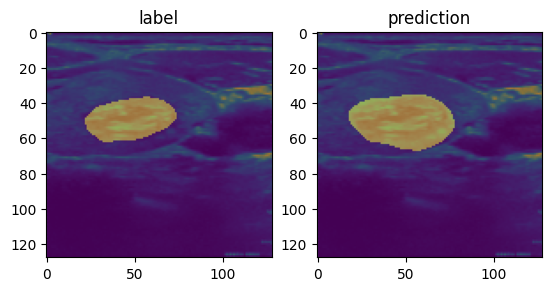

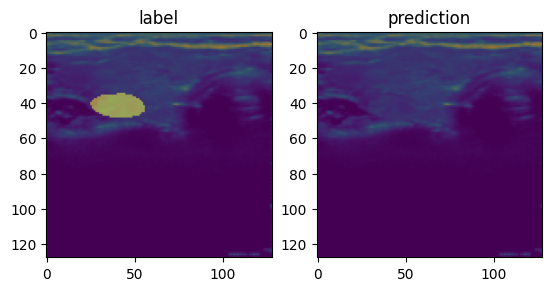

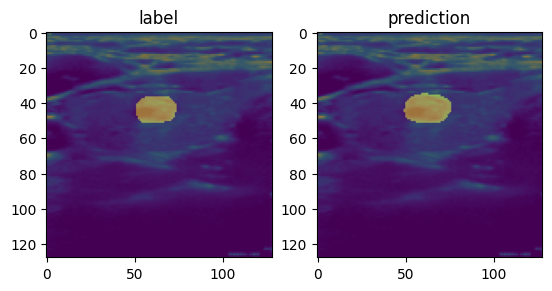

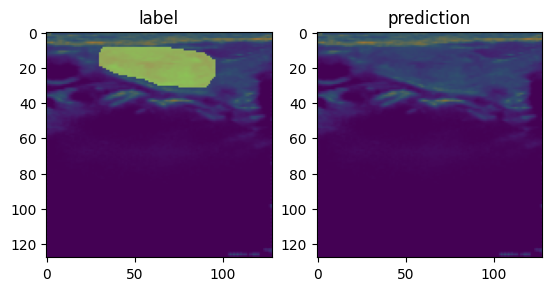

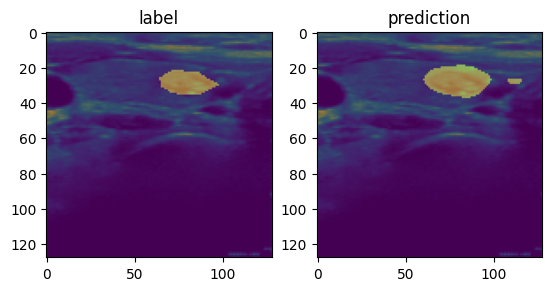

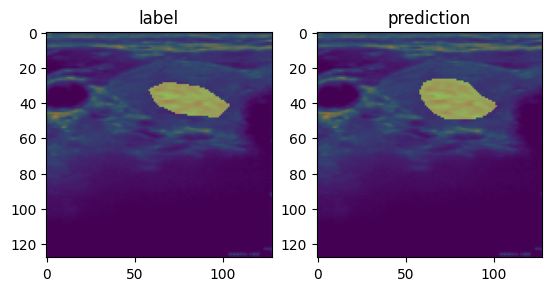

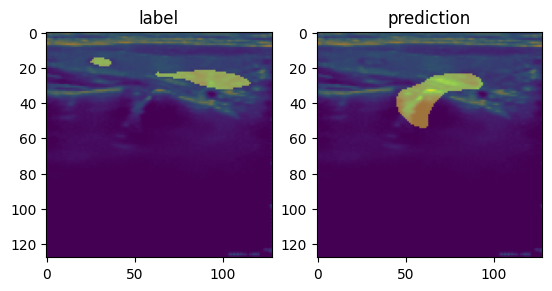

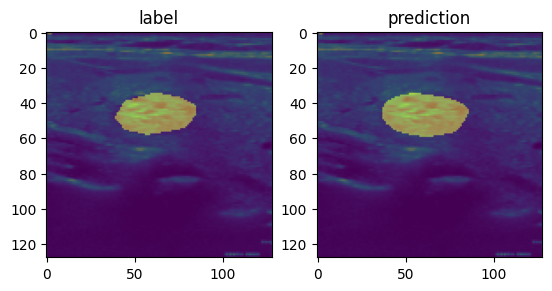

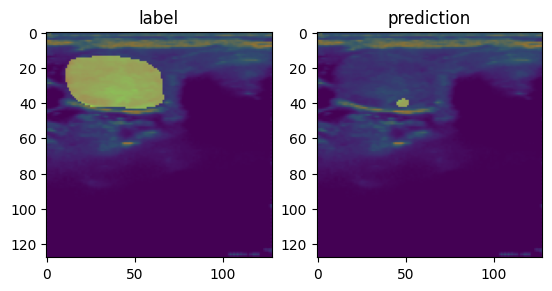

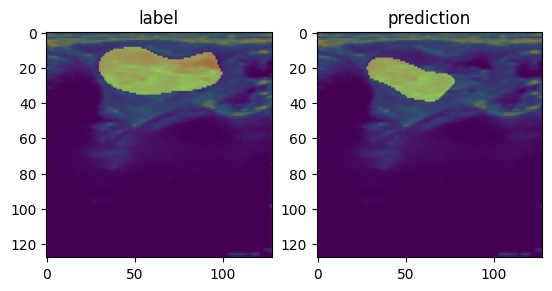

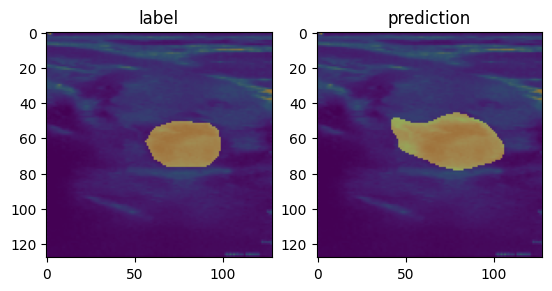

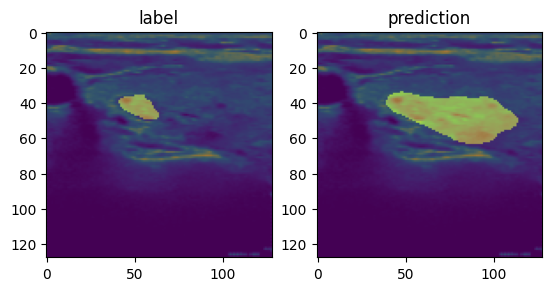

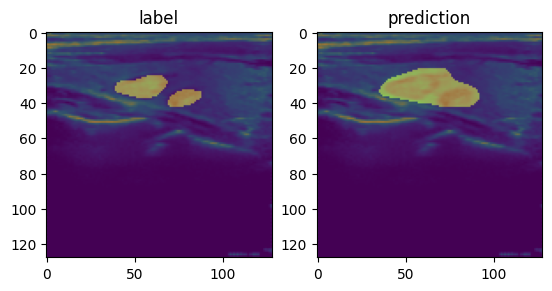

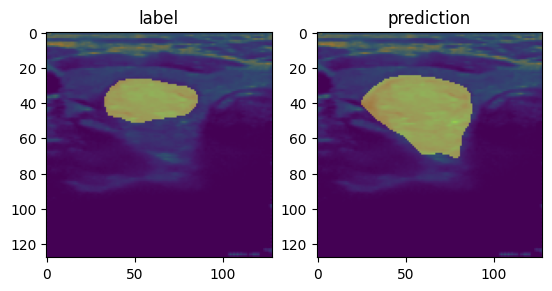

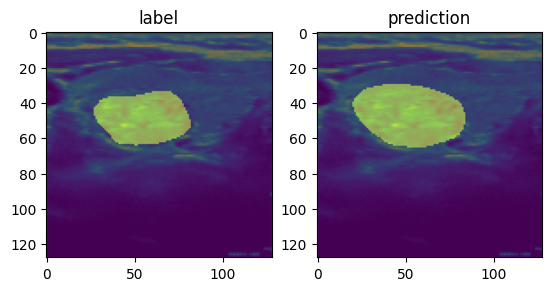

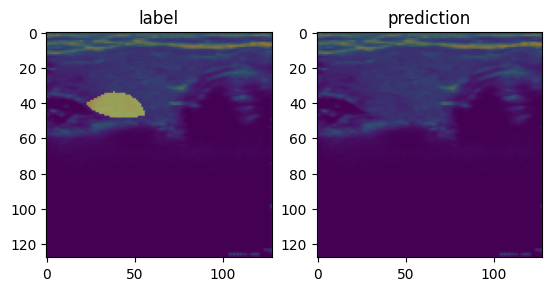

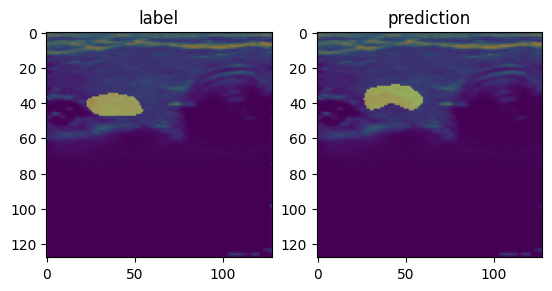

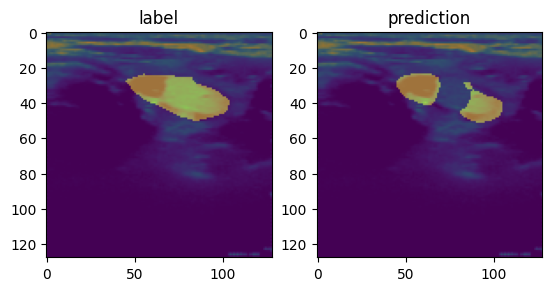

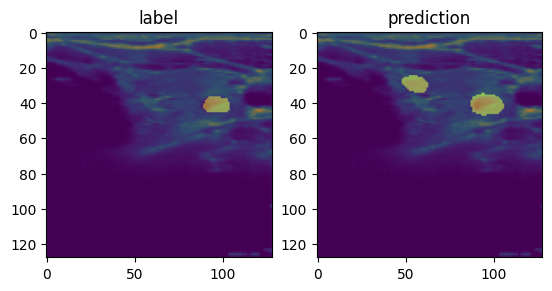

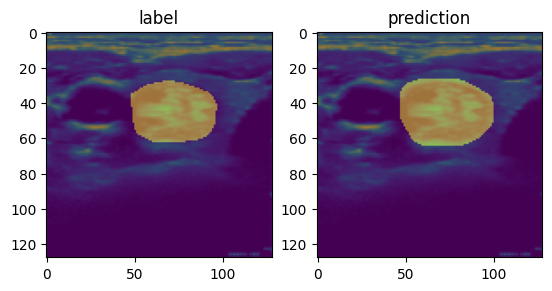

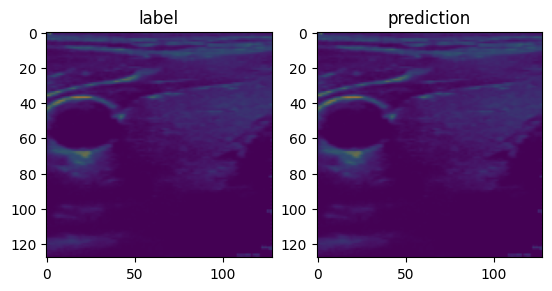

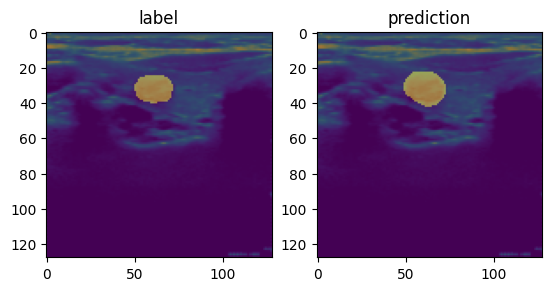

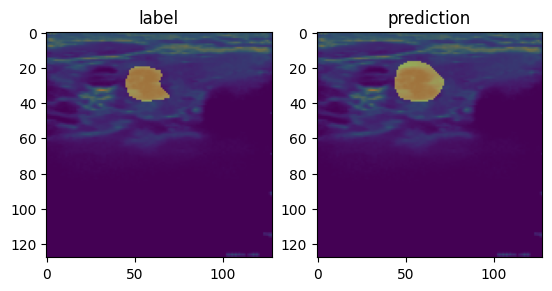

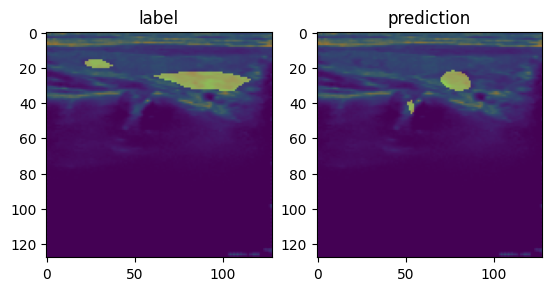

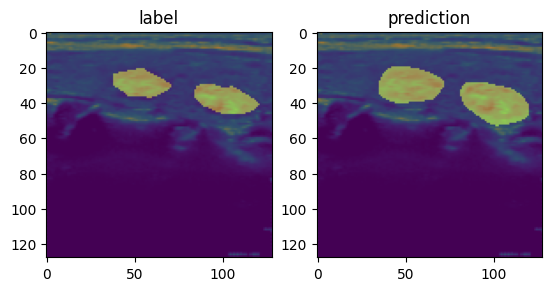

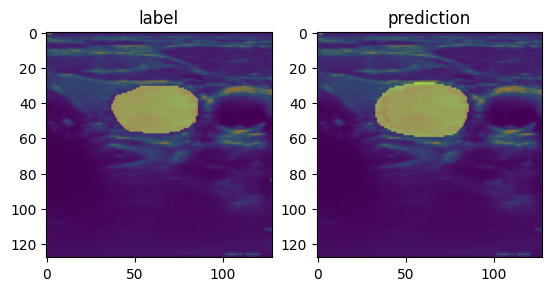

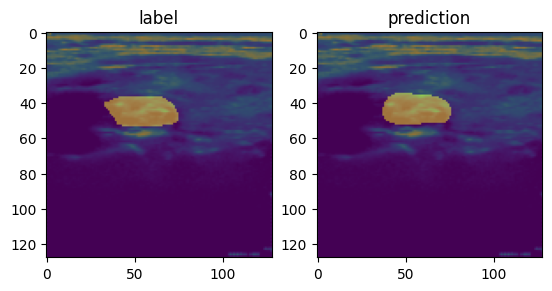

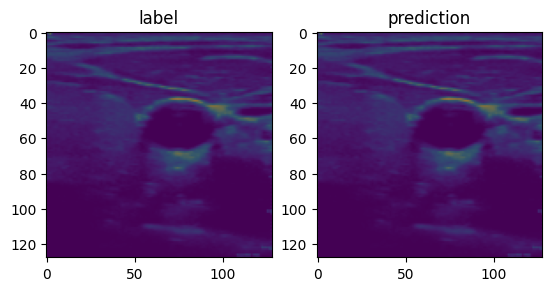

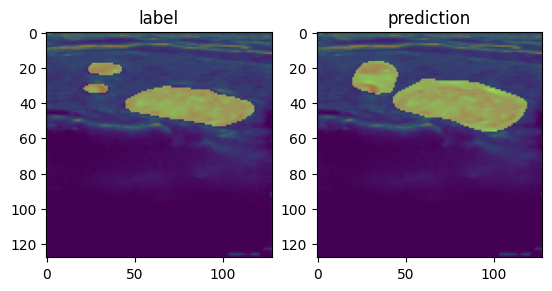

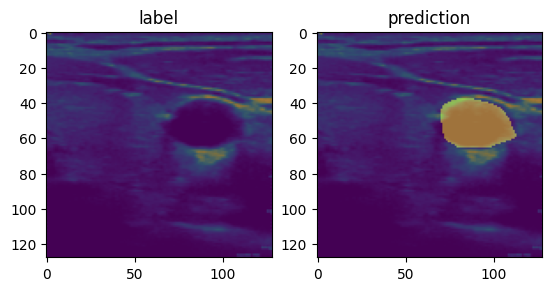

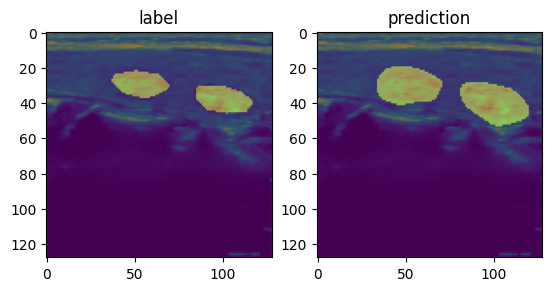

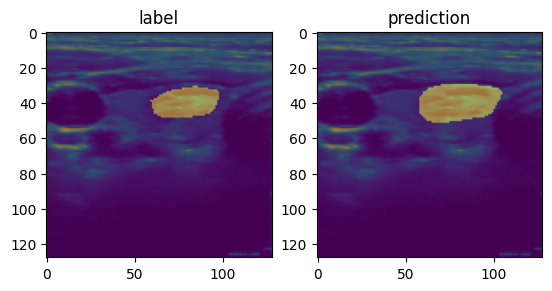

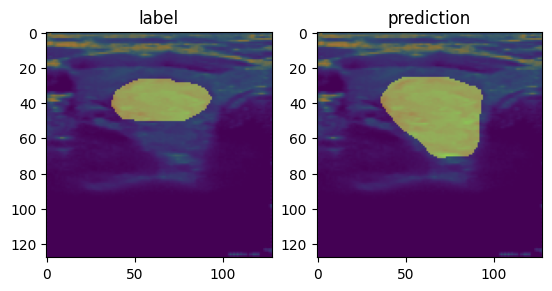

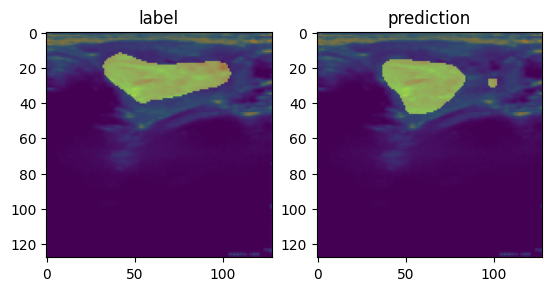

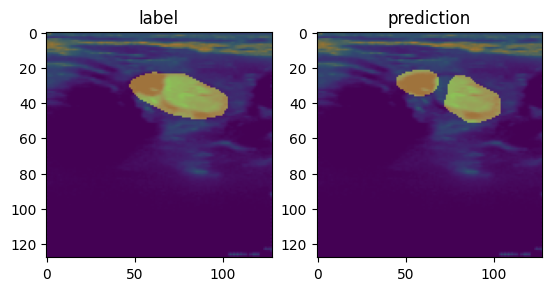

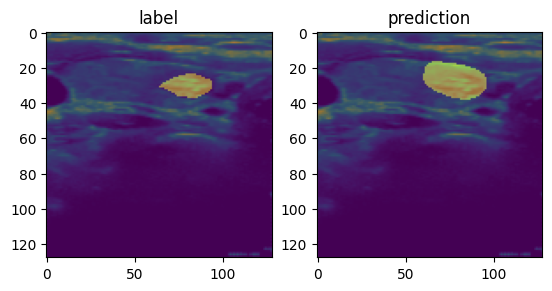

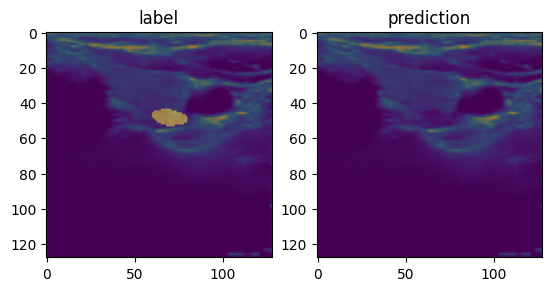

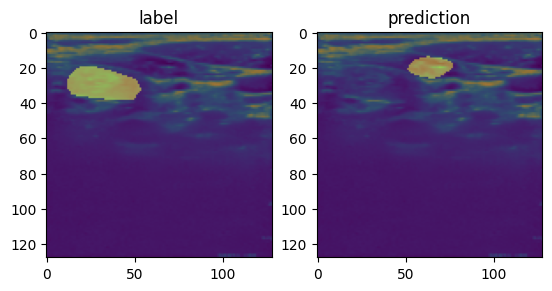

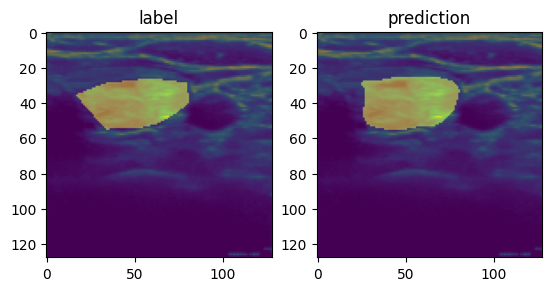

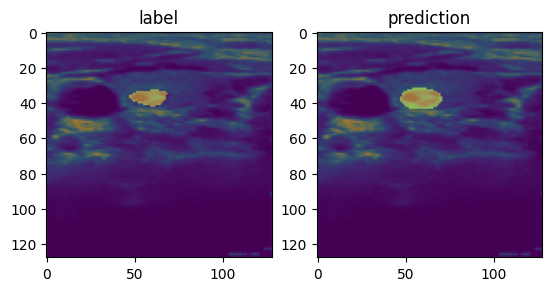

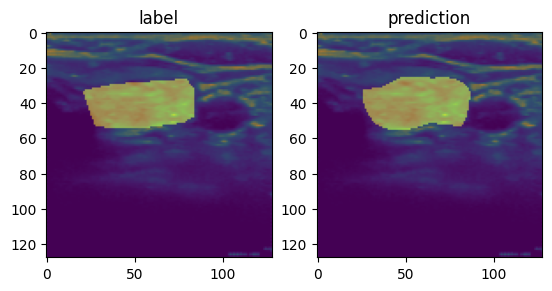

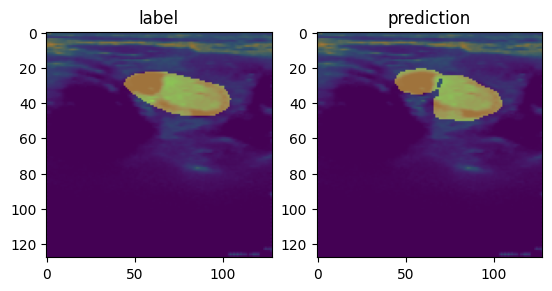

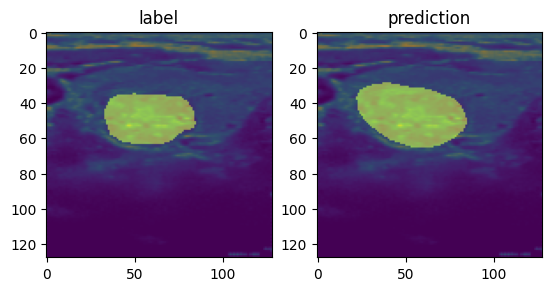

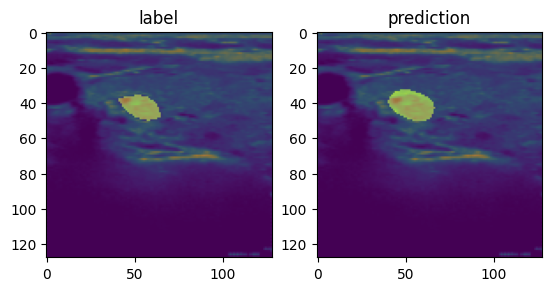

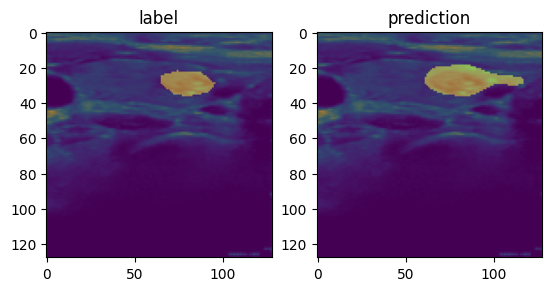

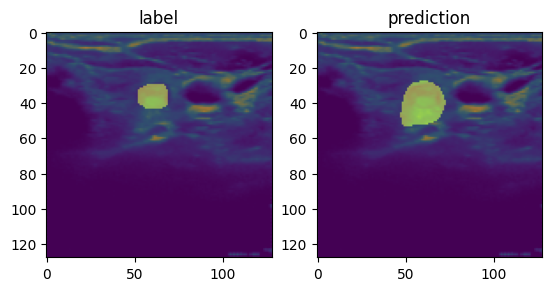

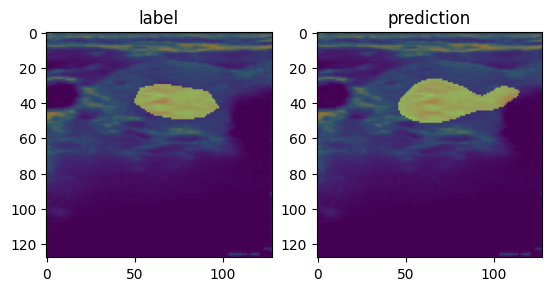

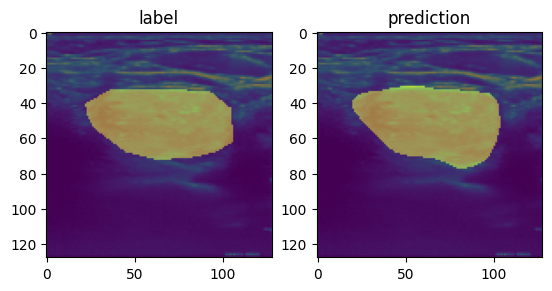

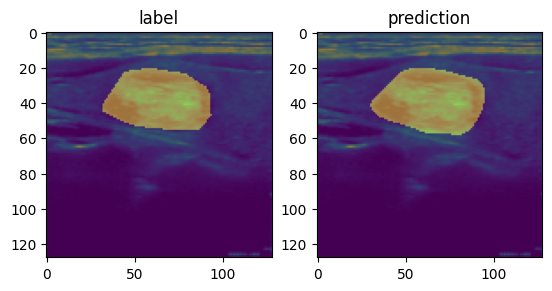

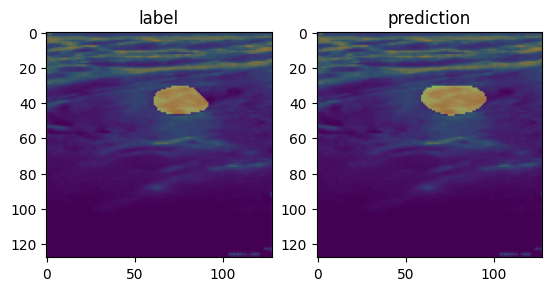

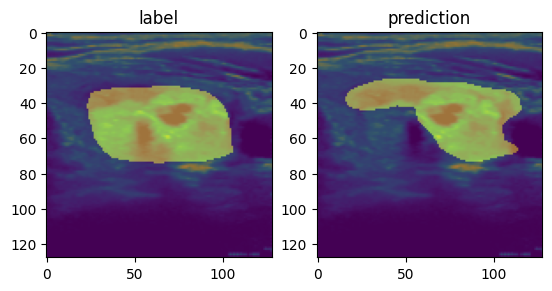

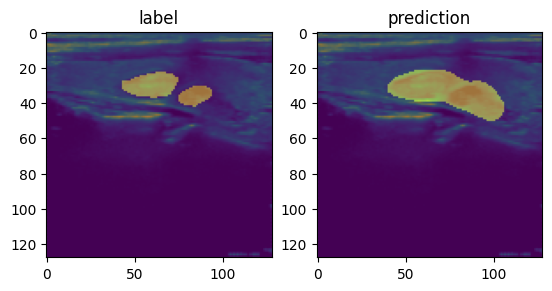

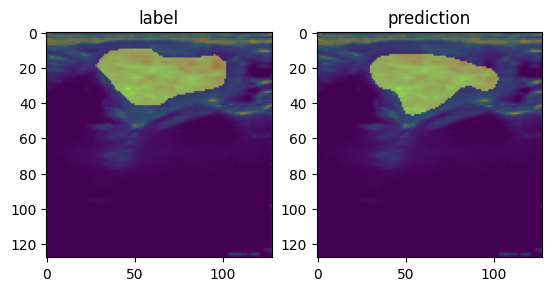

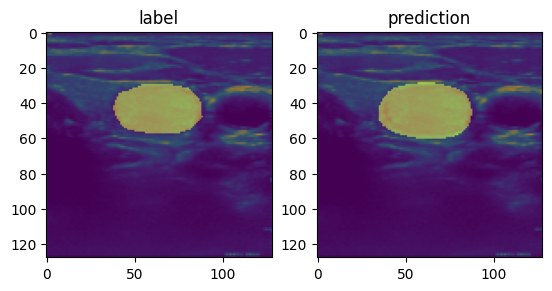

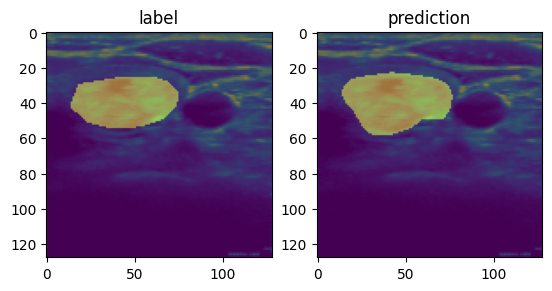

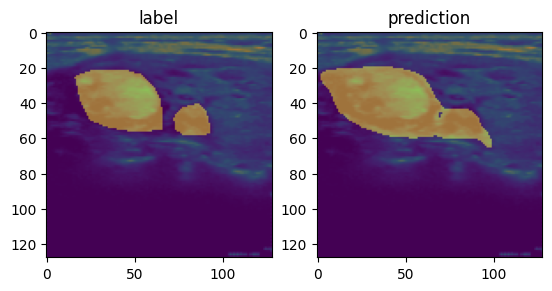

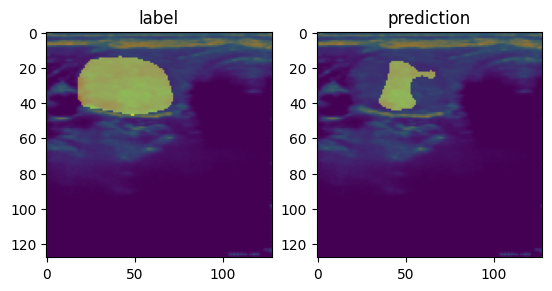

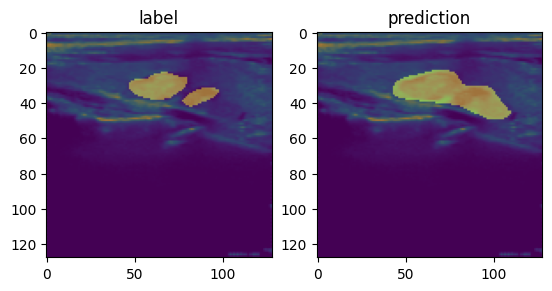

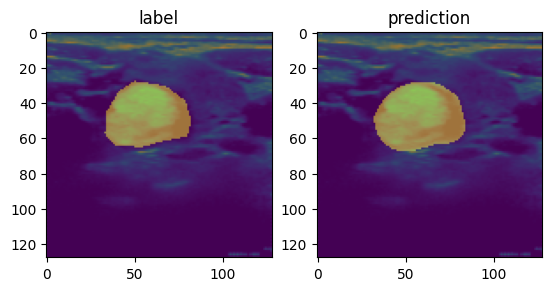

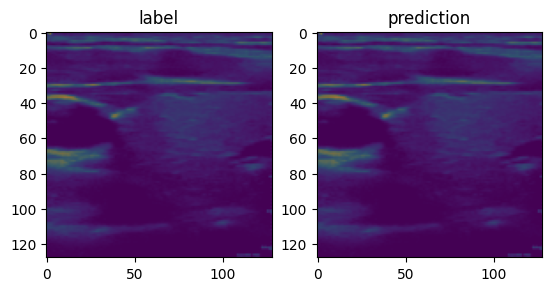

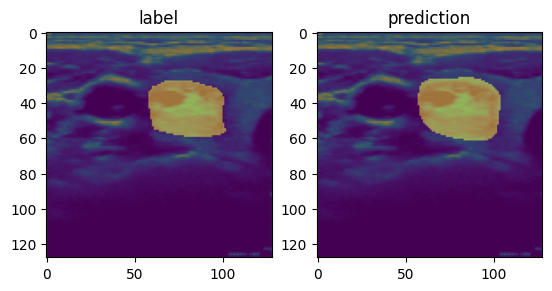

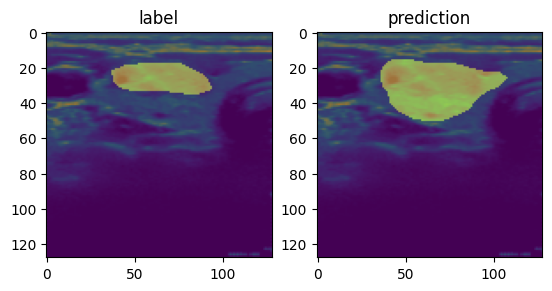

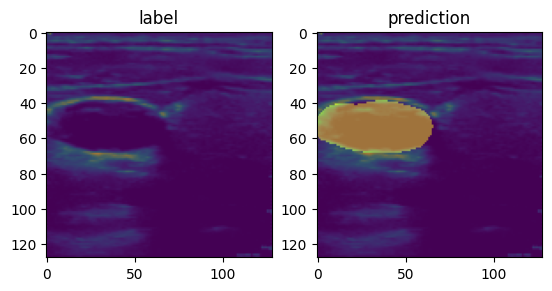

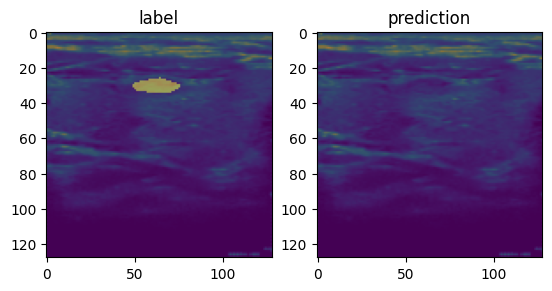

In [50]:
indexs = [9, 15, 2, 8]
for index in range(outputs.shape[0]):
    
    plt.subplot(1,2,1)
    plt.imshow(image[index][0])
    plt.imshow(mask[index][0], alpha = 0.5)
    plt.title("label")
    
    outputs = outputs>0.5
    plt.subplot(1,2,2)
    plt.imshow(image[index][0])
    plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
    plt.title("prediction")
    plt.show()

In [ ]:
image.shape

In [ ]:
from_dataset.shape

In [15]:
DDTI_area_ratio = []
TN3K_area_ratio = []
DDTI_image_mean = []
TN3K_image_mean = []
for image, mask, seg_type, from_dataset in tqdm(test_dataloader):
    for i in range(image.shape[0]):
        if from_dataset[i]==1:
            # plt.imshow(image[i][0])
            # plt.show()
            DDTI_area_ratio.append(torch.sum(mask[i][0])/(mask.shape[2]*mask.shape[3]))
            DDTI_image_mean.append(torch.mean(image[i][0]))
        elif from_dataset[i]==3:
            TN3K_area_ratio.append(torch.sum(mask[i][0])/(mask.shape[2]*mask.shape[3]))
            TN3K_image_mean.append(torch.mean(image[i][0]))


00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.40it/s]

In [21]:
DDTI_area_ratio = []
TN3K_area_ratio = []
DDTI_image_mean = []
TN3K_image_mean = []
DDTI_image_std = []
TN3K_image_std = []
for image, mask, seg_type, from_dataset in tqdm(test_dataloader):
    for i in range(image.shape[0]):
        if from_dataset[i]==1:
            # plt.imshow(image[i][0])
            # plt.show()
            DDTI_area_ratio.append(torch.sum(mask[i][0])/(mask.shape[2]*mask.shape[3]))
            DDTI_image_mean.append(torch.mean(image[i][0]))
            DDTI_image_std.append(torch.std(image[i][0]))
        elif from_dataset[i]==3:
            TN3K_area_ratio.append(torch.sum(mask[i][0])/(mask.shape[2]*mask.shape[3]))
            TN3K_image_mean.append(torch.mean(image[i][0]))
            TN3K_image_std.append(torch.std(image[i][0]))


00%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.60it/s]

In [22]:
np.mean(DDTI_image_std)

0.2088157

In [23]:
np.mean(TN3K_image_std)

0.16833934

In [17]:
DDTI_image_std

[]

In [ ]:
np.mean(DDTI_area_ratio)

In [ ]:
np.mean(TN3K_area_ratio)

In [10]:
np.std(DDTI_image_mean)

0.036692772

In [11]:
np.std(TN3K_image_mean)

0.10103502